В данном ноутбуке будут рассмотрены некоторые варианты классификаторов, построенных на основе решающих деревьев.
Решающие деревья воспроизводят логические схемы, позволяющие
получить окончательное решение о классификации объекта с
помощью ответов на иерархически организованную систему вопросов.
Причём вопрос, задаваемый на последующем иерархическом уровне,
зависит от ответа, полученного на предыдущем уровне. Подобные
логические модели издавна используются в ботанике, зоологии,
минералогии, медицине и других областях. Пример, решающего
дерева, позволяющая грубо оценить стоимость квадратного метра
жилья в предполагаемом городе приведена на рисунке

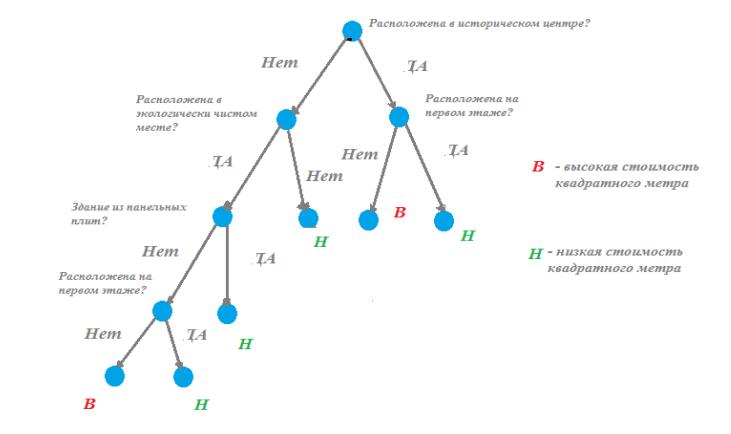

Для датасета смотрится фича, по которой разделяется наибольшее количество образцов, и так каждый раз. В случае, когда используется ensemble, стоится несколько деревьев, каждый из которых является слабым классификатором, но используя принцип голосования, получается хороший классификатор (или регрессор).

Gradient Boosting machine работает сходно с обычным ensemble, но каждое следующее дерево, в отличие от предыдущего случая, используется для того, чтобы улучшить результат работы всего предыдущего набора деревьев.



**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - class:
                - WDBC-Malignant
                - WDBC-Benign

    :Summary Statistics:

    ===================================== ====== ======
                                           Min    Max
    ===================================== ====== ======
    radius (mean):                        6.981  28.11
    texture (mean):                       9.71   39.28
    perimeter (mean):                     43.79  188.5
    area (mean):                          143.5  2501.0
    smoothness (mean):                    0.053  0.163
    compactness (mean):                   0.019  0.345
    concavity (mean):                     0.0    0.427
    concave points (mean):                0.0    0.201
    symmetry (mean):                      0.106  0.304
    fractal dimension (mean):             0.05   0.097
    radius (standard error):              0.112  2.873
    texture (standard error):             0.36   4.885
    perimeter (standard error):           0.757  21.98
    area (standard error):                6.802  542.2
    smoothness (standard error):          0.002  0.031
    compactness (standard error):         0.002  0.135
    concavity (standard error):           0.0    0.396
    concave points (standard error):      0.0    0.053
    symmetry (standard error):            0.008  0.079
    fractal dimension (standard error):   0.001  0.03
    radius (worst):                       7.93   36.04
    texture (worst):                      12.02  49.54
    perimeter (worst):                    50.41  251.2
    area (worst):                         185.2  4254.0
    smoothness (worst):                   0.071  0.223
    compactness (worst):                  0.027  1.058
    concavity (worst):                    0.0    1.252
    concave points (worst):               0.0    0.291
    symmetry (worst):                     0.156  0.664
    fractal dimension (worst):            0.055  0.208

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from graphviz import Source
import pydotplus
from IPython.display import SVG
import sklearn.ensemble as ensemble
from catboost import CatBoostClassifier 

In [39]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

In [40]:
np.random.seed = 12345

X = pd.DataFrame(load_breast_cancer()['data'], columns=load_breast_cancer()['feature_names'])
y = load_breast_cancer()['target']
X_train, X_test, y_train, y_test = train_test_split(X, y)

Посмотрим распределение классов. Если классы сильно неравномерно распределены, то, так как функции неравномерно распределены, то модели будет выгоднее предсказывать более частый класс, игнорируя существование второго класса.

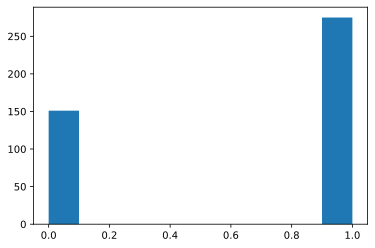

In [41]:
plt.hist(y_train)
plt.show()

In [58]:
def observe(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    def print_metric(y_true, y_pred):
        print(mean_absolute_error(y_true, y_pred), 'MAE')
        print(mean_squared_error(y_true, y_pred), 'MSE')
        print(roc_auc_score(y_true, y_pred), 'ROC-AUC')
        
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_metric(y_test, y_pred)
    try:
        dot_data = StringIO()
        export_graphviz(model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
        graph = Source(tree.export_graphviz(model, out_file=None, feature_names=X.columns, class_names=['0', '1'] ,filled = True))
        display(SVG(graph.pipe(format='svg')))
    except Exception:
        pass

0.08391608391608392 MAE
0.08391608391608392 MSE
0.9079368252698921 ROC-AUC


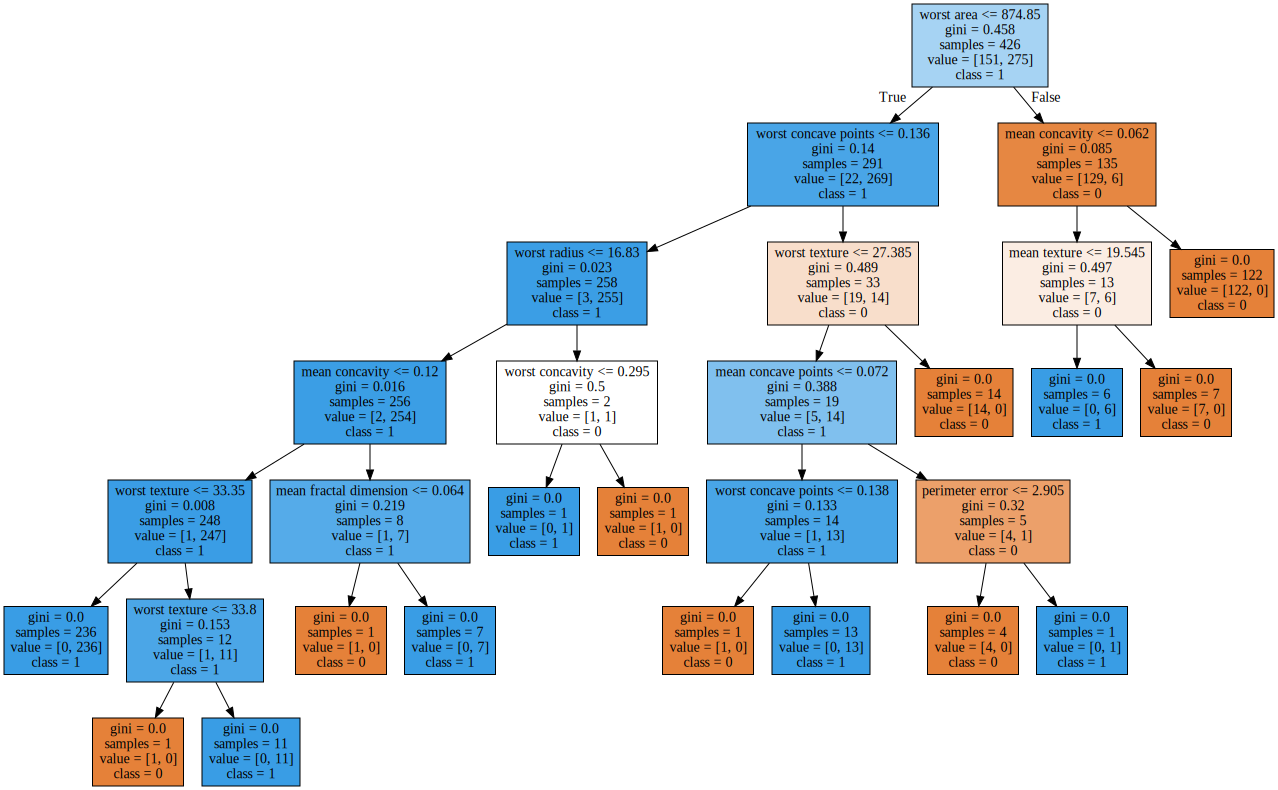

In [59]:
observe(tree.DecisionTreeClassifier())

In [66]:
parameters = {'max_depth':list(range(2, 10)), 'class_weight':[{0:1, 1:1}, {0:1.5, 1:1}], 'criterion':['gini', 'entropy']}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)
best = clf.best_params_
print(best)


{'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 5}


0.07692307692307693 MAE
0.07692307692307693 MSE
0.918232706917233 ROC-AUC


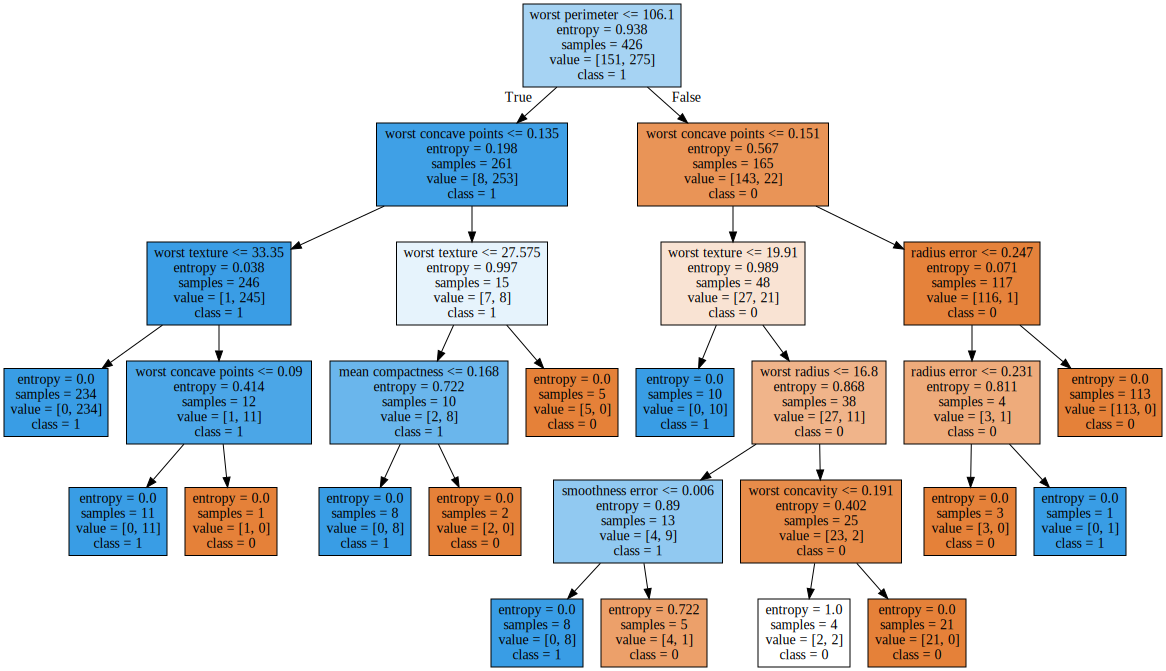

In [61]:
observe(tree.DecisionTreeClassifier(class_weight= {0: 1, 1: 1}, criterion= 'entropy', max_depth= 5))

Тут, как можно заметить, подбор оптимальных гиперпараметров, существенно влияет на качество модели. До этого использовалось только одно дерево, сейчас посмотрим, как будет выглядеть результат, елси использовать сразу много деревьев.

In [64]:
observe(ensemble.RandomForestClassifier())

0.06993006993006994 MAE
0.06993006993006994 MSE
0.9243302678928428 ROC-AUC


C:\Users\sevag\Anaconda3\envs\mechamt\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [68]:
parameters = {'n_estimators' : list(range(10,200, 10)), 'max_depth': list(range(3,15))}
clf = GridSearchCV(ensemble.RandomForestClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)
best = clf.best_params_
print(best)

{'max_depth': 7, 'n_estimators': 10}


In [71]:
observe(clf.best_estimator_)

0.06293706293706294 MAE
0.06293706293706294 MSE
0.9304278288684527 ROC-AUC


In [73]:
observe(CatBoostClassifier(verbose = 0))

0.04195804195804196 MAE
0.04195804195804196 MSE
0.9508196721311475 ROC-AUC
